TO_DO:

* calculate true coefficients
* plot residuals
* statistical output
* plot learning curve 

In [148]:
#import libraries

import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
SEED = 23

In [2]:
def Winsorization_Method(df_source, columns,  lower, upper):
    """
    Remove outliers from the given DataFrame based on the provided lower and upper percentiles.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame from which outliers will be removed.
    columns : list of str
        The names of the columns to consider for outlier removal.
    lower : float
        The lower percentile below which data points are considered as outliers.
    upper : float
        The upper percentile above which data points are considered as outliers.

    Returns:
    --------
    ratio : float
        The ratio of outliers in the original DataFrame, rounded to two decimal places.
    df_win : pandas.DataFrame
        A new DataFrame with the outliers removed.
    
    Example:
    --------
    >>> ratio, df_win = Winsorization_Method(df, ['A', 'B'], 10, 90)
    
    Notes:
    ------
    - The function makes a copy of the original DataFrame, so the original DataFrame remains unchanged.
    - Outliers are determined separately for each column and are not considered across multiple columns.

    """
    #Data preparation
    df = df_source.copy()
    df = df[columns]

    #Determining records with outliers
    outliers=[]
    
    for col in columns:
        q1 = np.percentile(df[col], lower)
        q2 = np.percentile(df[col], upper)
        
        for pos in range(len(df)):
            if df[col].iloc[pos]>q2 or df[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers = set(outliers)                   
    outliers = list(outliers)
    
    ratio= round(len(outliers)/len(df)*100, 2) #calculating the ratio of outliers in the original data                     
    df_win = df.drop(df.index[outliers]) #drop outliers 
    
    return ratio, df_win

In [3]:
def high_corr(df_source, method='spearman', thsld=0.8, perc=0.95):
    """
    Remove columns from a DataFrame that are highly correlated with other columns.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame for which to identify and remove highly correlated columns.

    method : str, optional
        The correlation method to be used. 'pearson', 'kendall', 'spearman' are supported. 
        Default is 'spearman'.

    thsld : float, optional
        The absolute correlation threshold. Pairs of columns with correlation higher than this value 
        will be considered for removal. Default is 0.8.

    perc : float, optional
        The percentile to use for deciding which variable to remove from a highly correlated pair.
        Should be between 0 and 1. Default is 0.95.

    Returns:
    --------
    df : pandas.DataFrame
        A new DataFrame with highly correlated columns removed.

    Notes:
    ------
    - For each pair of highly correlated columns, the function removes the one with the higher
      percentile value of correlation, based on the 'perc' parameter.
    - Prints out the columns that are removed and their percentile values.

    Example:
    --------
    >>> high_corr(df)
    Removing A with 0.95th percentile = 1.0
    Remaining columns: Index(['B', 'C'], dtype='object')
    """
    df =  df_source.copy()
    corr = df.corr(method)
    high_corr_vars = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > thsld:
                colname_i = corr.columns[i]
                colname_j = corr.columns[j]

                # Calculate mean correlation for each variable
                perc_i = np.percentile(corr[colname_i], perc)
                perc_j = np.percentile(corr[colname_j], perc)

                # Decide which variable to remove from each correlated pair based on its highest percentile value in the correlation matrix.
                max_abs_value = max(abs(perc_i), abs(perc_j))
                if max_abs_value >= thsld:
                    if abs(perc_i) > abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))
                else:
                    if abs(perc_i) <= abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))

                    

    # Remove the variable with the highest mean correlation from each pair
    for var, perc_val in high_corr_vars:
        if var in df.columns:
            print(f"Removing {var} with {perc}th percentile = {perc_val}")
            del df[var]

    print("Remaining columns:", df.columns)
    return df

In [102]:
def grid_log_c (X_train, y_train, X_test, y_test, C_values, penalty='l1', random_state = 23):
        """
    Evaluates and plots the train and test accuracy of a logistic regression model for various C values.

    Parameters:
    -----------
    X_train : array-like or DataFrame
        The features for the training set.
    y_train : array-like or DataFrame
        The target variable for the training set.
    X_test : array-like or DataFrame
        The features for the test set.
    y_test : array-like or DataFrame
        The target variable for the test set.
    C_values : list of floats
        The list of C values to evaluate. C is the inverse regularization strength.
    penalty : str, optional
        The penalty type to use in the logistic regression model ('l1' or 'l2'). Default is 'l1'.
    random_state : int, optional
        The number used to initialize a pseudorandom number generator, which is used for reproducibility of the results.

    Returns:
    --------
    train_accuracies : list of floats
        The train accuracies for the different C values.
    test_accuracies : list of floats
        The test accuracies for the different C values.
    
    Notes:
    ------
    - This function uses a log scale for the C values on the x-axis of the plot.
    - The solver used is 'liblinear' to allow both 'l1' and 'l2' penalty parameters.

    Example:
    --------
    >>> C_values = [0.001, 0.01, 0.1, 1, 10]
    >>> grid_log_c(X_train, y_train, X_test, y_test, C_values, 32)

    """
    
    train_accuracies = []
    test_accuracies = []
    
    # Implement a model
    for c in C_values:
        lr = LogisticRegression(C=c, solver='liblinear', penalty = 'l1', random_state = seed)  
        lr.fit(X_train, y_train)

        train_accuracy = lr.score(X_train, y_train)
        test_accuracy = lr.score(X_test, y_test)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    
    # Draw a plot
    plt.figure(figsize=(10, 6))
    plt.plot(C_values, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(C_values, test_accuracies, label='Test Accuracy', marker='^')
    plt.xscale('log')  
    plt.xlabel('C Value (log scale)')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy for Different C Values')
    plt.legend()
    plt.show()
    
    return train_accuracies, test_accuracies

In [105]:
def plot_grid_search(cv_results, grid_params):
    """
    Plots the test scores from a Grid Search as either a line plot or heatmap based on the number of hyperparameters.

    Parameters:
    -----------
    cv_results : dict
        A dictionary of cross-validation results, usually obtained from `GridSearchCV.cv_results_`.
    
    grid_params : list of str
        A list of hyperparameter names that are part of the grid search.

    Returns:
    --------
    None

    Notes:
    ------
    - If there's only one hyperparameter, the function will plot a line plot.
    - If there are two hyperparameters, the function will plot a heatmap.
    - If there are more than two hyperparameters, the function will print a message indicating its limitation.
    
    Example:
    --------
    >>> plot_grid_search(cv_results, ['param1', 'param2'])
    [Heatmap is displayed]

    >>> plot_grid_search(cv_results, ['param1'])
    [Line plot is displayed]
    """
    #Convert to DataFrame
    results = pd.DataFrame(cv_results)

    # If only one hyperparameter, plot a line plot
    if len(grid_params) == 1:
        param = 'param_' + grid_params[0]
        plt.figure(figsize=(8, 6))
        plt.plot(results[param], results['mean_test_score'], marker='o')
        plt.xlabel(grid_params[0])
        plt.ylabel('Mean Test Score')
        plt.title(f"Grid Search Test Scores")
        plt.show()
    
    # If two hyperparameters, plot a heatmap
    elif len(grid_params) == 2:
        pivot_table = results.pivot(index=f'param_{grid_params[0]}', 
                                    columns=f'param_{grid_params[1]}', 
                                    values='mean_test_score')
        sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
        plt.xlabel(grid_params[1])
        plt.ylabel(grid_params[0])
        plt.title(f"Grid Search Test Score Heatmap")
        plt.show()

    # For more than two hyperparameters, print a message
    else:
        print("The function is designed to plot up to two hyperparameters.")

In [183]:
def feature_importance_logreg(logistic_model, cut_off=None):
    """
    Plots feature importances for a logistic regression model using L1 regularisation.

    Parameters:
    ----------
    logistic_model : sklearn.linear_model object
        The logistic regression model.

    cut_off : float, optional
        The cut-off value to consider for feature importance.

    Returns:
    -------
    feature_df : pandas DataFrame
        A DataFrame containing the features sorted by their importance.
        
    omitted_df : pandas DataFrame
        A DataFrame containing the features that were omitted based on the cut-off value.
    """
    # Get feature importances
    feature_importance_values = np.abs(logistic_model.coef_)
    
    # Sort feature importances
    indices = np.argsort(feature_importance_values[0])[::-1]
    
    sorted_feature_names = [X_train.columns[i] for i in indices]
    sorted_importance_values = [feature_importance_values[0][i] for i in indices]
    
    # Apply cutoff if specified
    if cut_off is not None:
        omitted_feature_names = [name for i, name in enumerate(sorted_feature_names) if sorted_importance_values[i] < cut_off]
        omitted_importance_values = [value for value in sorted_importance_values if value < cut_off]
        
        sorted_feature_names = [name for name in sorted_feature_names if name not in omitted_feature_names]
        sorted_importance_values = [value for value in sorted_importance_values if value >= cut_off]
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importance (Logistic Regression)")
    plt.bar(range(len(sorted_importance_values)), sorted_importance_values, align="center")
    plt.xticks(range(len(sorted_importance_values)), sorted_feature_names, rotation=90)  # Add rotation for better visibility
    plt.xlabel("Feature Name")
    plt.ylabel("Absolute Coefficient Value")
    plt.show()
    
    # Create a DataFrame for sorted feature importances
    feature_df = pd.DataFrame({
        'Feature': sorted_feature_names,
        'Importance': sorted_importance_values
    })
    
    # Create a DataFrame for omitted feature importances
    omitted_df = pd.DataFrame({
        'Omitted Feature': omitted_feature_names,
        'Omitted Importance': omitted_importance_values
    })
    
    return feature_df, omitted_df

# Data import and transformation

In [4]:
#load the data

df = pd.read_csv('D:/Extra study/datasets/taiwanese+bankruptcy+prediction/data.csv')

In [5]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [7]:
#check the types

print(df.dtypes.value_counts())

float64    93
int64       3
Name: count, dtype: int64


In [8]:
#check the nulls

df.isnull().any().any()

False

In [9]:
#basic statistics

df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

In [10]:
num_cols = df.select_dtypes(include=['float64']).columns

## cutting outliers

In [11]:
ratio, df_win = Winsorization_Method(df, num_cols, lower=0.03, upper=99.7)

In [12]:
print(f"Ratio of Outliers Detected in the dataset:{ratio}")

Ratio of Outliers Detected in the dataset:13.18


In [13]:
df.shape

(6819, 96)

## correlation 

<Axes: >

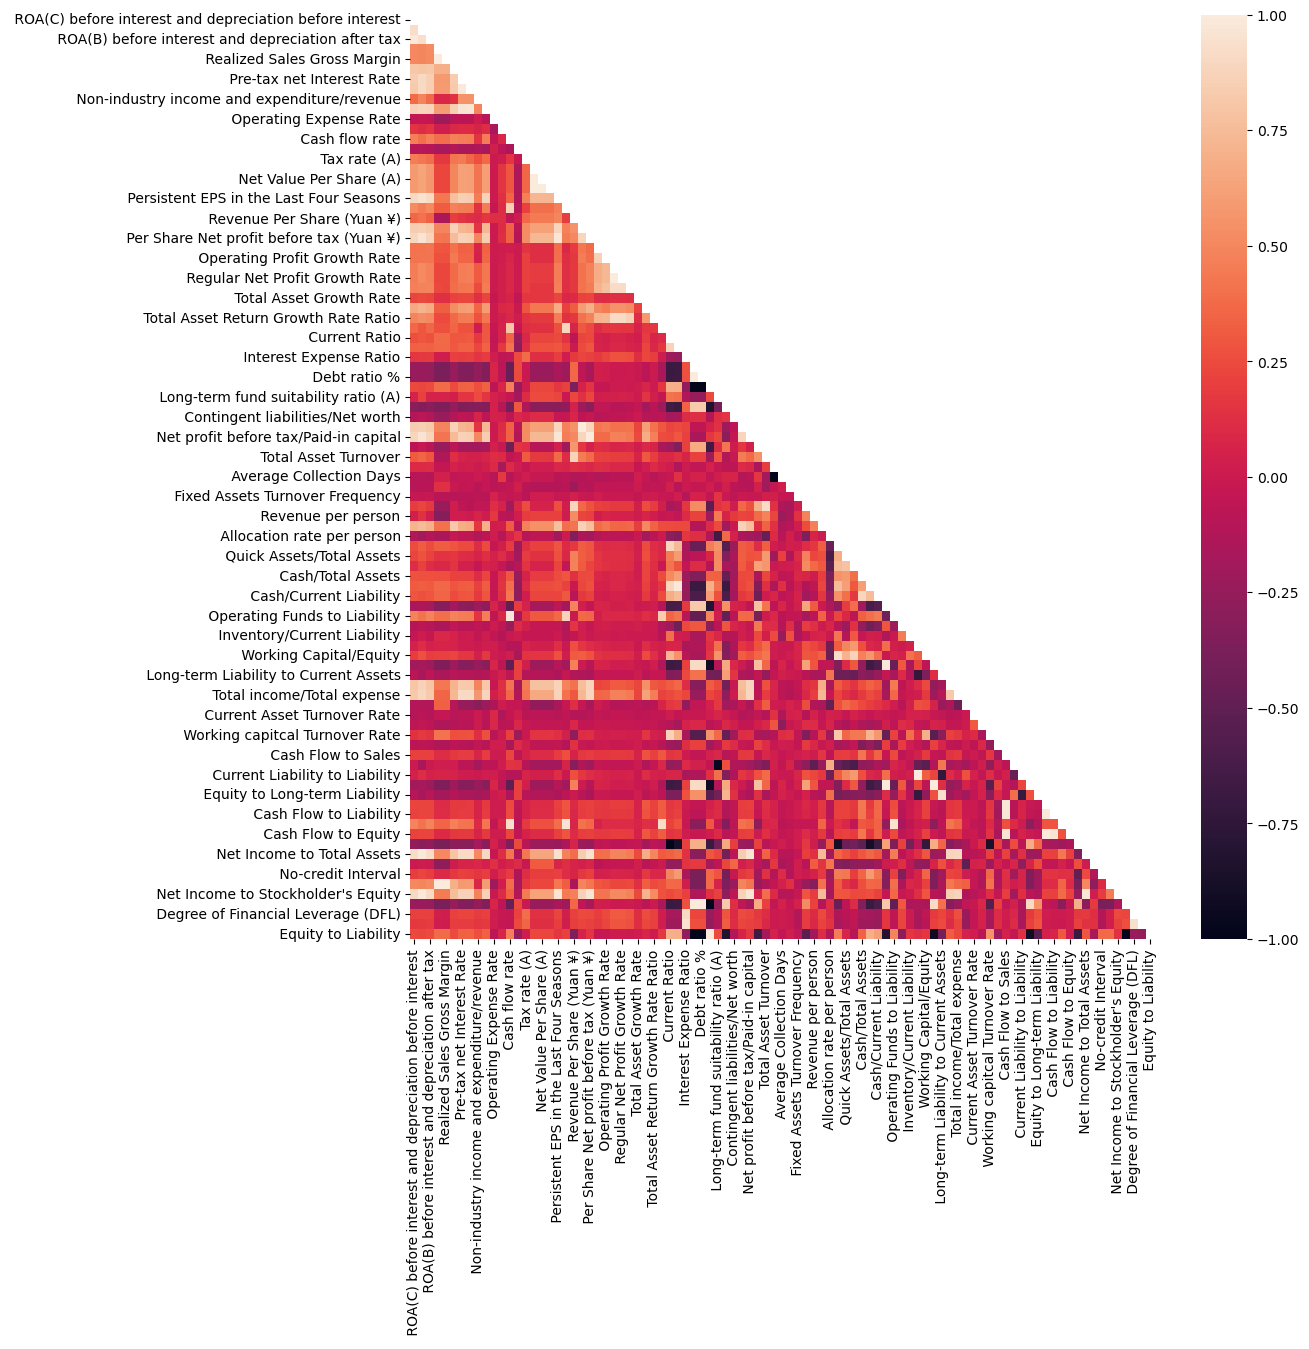

In [14]:
#calculating correlation matrix

corr = df_win.corr('spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask)

In [15]:
#remove highly correlated vavariables 

df_cut = high_corr(df_win)

Removing  ROA(C) before interest and depreciation before interest with 0.95th percentile = -0.26923134487389067
Removing  ROA(B) before interest and depreciation after tax with 0.95th percentile = -0.2717317585323681
Removing  Operating Gross Margin with 0.95th percentile = -0.38068936752085847
Removing  Operating Profit Rate with 0.95th percentile = -0.2613301966896011
Removing  ROA(A) before interest and % after tax with 0.95th percentile = -0.2989602762430868
Removing  Pre-tax net Interest Rate with 0.95th percentile = -0.3340891378811344
Removing  Continuous interest rate (after tax) with 0.95th percentile = -0.3298412243657563
Removing  Net Value Per Share (B) with 0.95th percentile = -0.2740619873619708
Removing  Net Value Per Share (C) with 0.95th percentile = -0.2739282304977576
Removing  Persistent EPS in the Last Four Seasons with 0.95th percentile = -0.24531763857608666
Removing  Cash Flow Per Share with 0.95th percentile = -0.21695616637913726
Removing  Operating Profit Per

In [16]:
df_cut.shape

(5920, 39)

In [17]:
df['Bankrupt?'].value_counts(normalize = True)

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

In [18]:
cat_cols = df.select_dtypes(include=['int64']).columns[1:]
cat_cols

Index([' Liability-Assets Flag', ' Net Income Flag'], dtype='object')

In [19]:
final_df = pd.concat([df_cut, df[cat_cols], df['Bankrupt?']], axis=1).dropna()
final_df

,Realized Sales Gross Margin,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (A),Realized Sales Gross Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Interest Expense Ratio,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Allocation rate per person,Quick Assets/Total Assets,Cash/Current Liability,Current Liability to Assets,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Long-term Liability to Current Assets,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Cash Flow to Liability,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Liability-Assets Flag,Net Income Flag,Bankrupt?
0,0.601457,0.302646,1.256969e-04,0.000000e+00,0.458143,0.000725,0.000000,0.147950,0.022102,0.217535,4.980000e+09,0.000327,0.002259,0.629951,0.005024,0.390284,0.006479,0.398036,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.037135,0.166673,1.473360e-04,0.147308,0.276920,0.001036,0.676269,2.559237e-02,0.064856,7.010000e+08,6.550000e+09,4.580000e+08,0.458609,0.716845,0.009219,0.622879,0,1,1
2,0.601364,0.302035,2.361297e-04,2.550000e+07,0.458521,0.000790,0.000000,0.177911,0.022760,0.217601,7.280000e+09,0.000396,0.011543,0.629631,0.005100,0.379093,0.006562,0.406580,0.004227,6.500000e+07,2.650000e+09,0.013387,0.028997,0.141016,0.340201,5.340000e+09,0.098162,0.277456,0.013879,0.446027,3.715116e-03,0.021387,1.791094e-03,1.022676e-03,7.610000e+08,0.459254,0.774670,0.040003,0.623841,0,1,1
3,0.583541,0.303350,1.078888e-04,0.000000e+00,0.465705,0.000449,0.000000,0.154187,0.022046,0.217568,4.880000e+09,0.000382,0.004194,0.630228,0.005047,0.379743,0.005366,0.397925,0.003215,7.130000e+09,9.150000e+09,0.028065,0.015463,0.021320,0.161575,1.010646e-03,0.098715,0.276580,0.003540,0.615848,2.216520e-02,0.024161,8.140000e+09,6.050000e+09,2.030000e+09,0.448518,0.739555,0.003252,0.622929,0,1,1
4,0.598783,0.303475,7.890000e+09,0.000000e+00,0.462746,0.000686,0.000000,0.167502,0.022096,0.217626,5.510000e+09,0.000439,0.006022,0.636055,0.005303,0.375025,0.006624,0.400079,0.004367,1.633674e-04,2.935211e-04,0.040161,0.058111,0.023988,0.260330,6.804636e-04,0.110195,0.287913,0.004869,0.975007,0.000000e+00,0.026385,6.680000e+09,5.050000e+09,8.240000e+08,0.454411,0.795016,0.003878,0.623521,0,1,1
6,0.619950,0.302814,3.984834e-04,7.300000e+08,0.461020,0.000805,0.000000,0.158822,0.022112,0.217604,5.720000e+09,0.000352,0.004672,0.629988,0.005005,0.384999,0.008044,0.400574,0.003805,1.620299e-04,1.452476e-04,0.040806,0.011460,0.009703,0.255093,1.050312e-03,0.115920,0.276643,0.002159,0.508089,9.347426e-03,0.092802,1.058011e-04,9.560000e+09,2.390000e+09,0.457785,0.736619,0.018372,0.623655,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6812,0.613168,0.303543,2.842345e-04,1.305649e-04,0.462196,0.000798,0.297803,0.169399,0.022150,0.217643,6.390000e+09,0.000449,0.012893,0.630703,0.006754,0.369639,0.005366,0.399177,0.002605,7.910000e+09,8.200436e-04,0.033548,0.012714,0.001955,0.221664,7.197433e-03,0.064763,0.277461,0.017426,0.952749,9.270000e+08,0.057486,9.070000e+09,4.440000e+09,5.400000e+09,0.455594,0.806743,0.000548,0.623743,0,1,0
6814,0.604462,0.303510,1.510213e-04,4.500000e+09,0.463734,0.000179,0.113372,0.175045,0.022374,0.217635,7.070000e+09,0.000450,0.010451,0.631415,0.005150,0.373823,0.005366,0.404804,0.009177,4.030000e+07,1.429781e-04,0.027903,0.006348,0.006312,0.312840,5.071548e-03,0.103838,0.277543,0.013212,0.786888,1.792237e-03,0.0

## train-test split

In [121]:
X_train, X_test, y_train, y_test= train_test_split(final_df.drop("Bankrupt?", axis=1),
                                                   final_df["Bankrupt?"],test_size=0.1, random_state=SEED,
                                                   stratify = final_df["Bankrupt?"])

In [122]:
num_cols_new = df_cut.select_dtypes(include=['float64']).columns

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train[num_cols_new])
X_test_std = scaler.transform(X_test[num_cols_new])

## scaling

In [123]:
X_train_scaled_df = pd.DataFrame(X_train_std, columns=num_cols_new)
X_test_scaled_df = pd.DataFrame(X_test_std, columns=num_cols_new)

# Concatenating scaled and categorical data
X_train_final = pd.concat([X_train_scaled_df, X_train[cat_cols].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test[cat_cols].reset_index(drop=True)], axis=1)

In [124]:
X_test_final.shape

(592, 41)

In [125]:
X_test_final

,Realized Sales Gross Margin,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (A),Realized Sales Gross Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Interest Expense Ratio,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Allocation rate per person,Quick Assets/Total Assets,Cash/Current Liability,Current Liability to Assets,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Long-term Liability to Current Assets,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Cash Flow to Liability,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Liability-Assets Flag,Net Income Flag
0,-1.327923,-1.127278,2.197300,-0.024986,-0.158610,-0.139014,-0.882614,-0.817189,-0.539047,0.021671,-0.352879,-0.763892,-0.078809,-0.089324,-0.368330,-0.647657,5.872681,-0.793141,-1.043945,2.144248,-0.406687,-0.617960,-0.426225,0.221680,-1.219496,-0.045505,-1.008480,0.074338,-0.080703,-0.116131,-0.085404,0.347124,-0.419278,1.070058,0.732090,-0.515492,-2.279869,-0.231919,0.063389,0,1
1,0.022088,0.018780,-0.619487,2.562864,0.202751,-0.139014,1.612368,-0.223351,-0.075439,0.034090,0.293927,-0.321418,-0.347257,-0.044566,-0.254357,-0.893441,-0.479022,0.010521,-0.592713,-0.669259,-0.406687,0.468618,-0.143050,-0.371583,0.083886,-0.045505,0.219260,0.019273,-0.080703,0.725289,-0.085404,1.086631,2.443662,1.282906,0.358464,-0.953190,0.200872,-0.248968,0.016730,0,1
2,-0.848202,-0.002782,-0.619487,-0.777044,-0.374060,-0.139014,-0.882614,-0.947237,-0.314542,-0.059776,1.249920,-0.689863,-0.731024,-0.952245,-0.313934,2.661352,-0.479022,1.445214,0.485676,-0.669259,-0.406687,0.513892,-0.362739,-0.376091,1.195871,-0.045505,2.833590,1.570073,-0.080703,0.876920,-0.085404,-0.276549,-0.419278,-0.638637,1.917502,0.014402,-0.785766,-0.206039,-0.036162,0,1
3,-0.686880,0.233748,1.351649,-0.777044,0.026727,-0.139014,1.547876,0.102554,-0.116680,0.050242,0.350789,-0.302698,-0.630194,0.047854,-0.246147,-0.175363,-0.024120,-0.404923,-0.104011,-0.669259,-0.406687,-0.242832,-0.458923,-0.391894,-0.638551,-0.045505,0.201629,0.291136,-0.080703,-0.018854,-0.085404,-0.791034,-0.419278,2.072217,1.547273,0.155576,-0.037288,-0.051098,-0.056905,0,1
4,-0.151970,-0.057668,-0.619487,-0.777044,-0.480078,-0.139014,-0.467690,0.328181,-0.073140,0.078240,0.361451,-0.328013,0.386883,0.231243,-0.259527,-0.587345,-0.479022,-0.364185,-0.220075,1.469252,-0.406687,-0.488606,-0.432878,-0.291912,0.760261,-0.045505,-0.394337,-0.047735,-0.080703,1.036438,-0.085404,-0.046424,-0.419278,-0.638637,-0.860914,-0.128472,-0.297518,-0.228044,0.118567,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,-0.074341,-0.095565,-0.619487,1.641111,0.187384,-0.139014,-0.048881,-0.140308,-0.041930,0.055558,0.389882,-0.254622,-0.503862,0.080782,-0.377626,-0.133416,-0.479022,0.178917,-0.248634,-0.669259,-0.406687,0.332795,-0.501955,-0.236063,-0.386483,-0.045505,0.187551,0.107170,-0.080703,-0.620617,-0.085404,0.065100,3.049556,1.537141,0.806815,0.030929,0.197598,-0.183813,0.002381,0,1
588,-0.720236,0.997569,1.087191,-0.462723,-0.974931,-0.139014,-0.654172,0.412791,0.144784,0.134536,-1.721833,0.155092,-0.045061,-0.048472,-0.031440,-0.541544,0.192290,-0.410368,0.599912,-0.669259,-0.406687,-0.333380,0.596631,-0.115718,-0.280675,-0.045505,-0.855156,-0.095742,-0.080703,0.255979,-0.085404,-0.919418,3.099162,-0.638637,-0.100076,-0.608706,1.189366,-0.204131,0.196433,0,1
589,0.940290,-0.362151,-0.619487,-0.77704

In [126]:
X_train_final.shape

(5328, 41)

## Synthetic Minority Over-sampling Technique

In [127]:
smote= SMOTE(sampling_strategy='minority', random_state=SEED)
X_train_smote, y_train_smote= smote.fit_resample(X_train_final, y_train)

In [128]:
y_train_smote.value_counts(normalize = True)

Bankrupt?
0    0.5
1    0.5
Name: proportion, dtype: float64

# Model implementation

In [134]:
model = LogisticRegression(random_state=SEED, max_iter = 1000)
model.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000, random_state=23)

## model asessment

In [135]:
model.score(X_train_smote, y_train_smote)

0.8986290789727747

In [136]:
y_pred = model.predict(X_test_final)
probs = model.predict_proba(X_test_final)

In [137]:
accuracy_score(y_test, y_pred)

0.8851351351351351

In [138]:
pd.crosstab(y_pred, y_test, colnames=['Prediction'])

Prediction,0,1
row_0,,
0,508,1
1,67,16


In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       575
           1       0.19      0.94      0.32        17

    accuracy                           0.89       592
   macro avg       0.60      0.91      0.63       592
weighted avg       0.97      0.89      0.92       592



## tunning

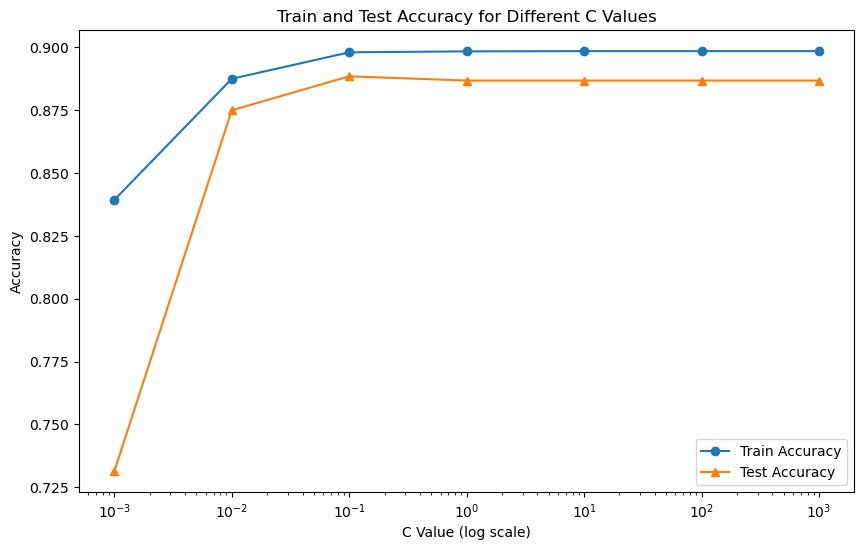

In [142]:
# Test accuracy is higher than train - lets try to improve test accuracy be regularization
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
grid_log_c(X_train_smote, y_train_smote, X_test_final, y_test, C_values)

In [145]:
#GridSearch

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

In [160]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED) #cross-validation 
grid_search = GridSearchCV(LogisticRegression(random_state = SEED, max_iter = 1000), param_grid, cv=cv, scoring='accuracy',
                          n_jobs = -1)
grid_search.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, random_state=23),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy')

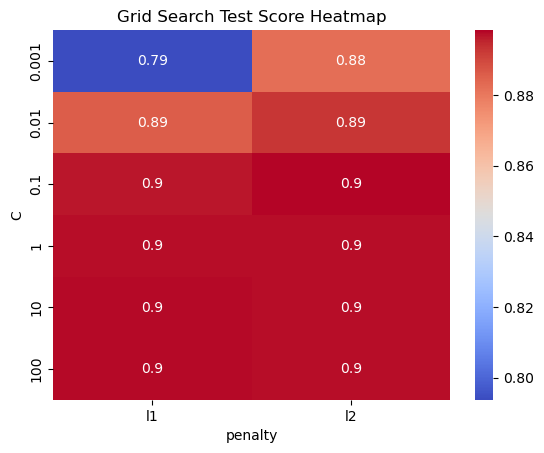

In [153]:
# extend regularization by adding l1 
plot_grid_search(grid_search.cv_results_, ['C', 'penalty'])

# Feature importance

In [157]:
# Create a logistic regression object with an L1 penalty
logistic_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)

# Fit the model
logistic_l1.fit(X_train_smote, y_train_smote)

# Get the model's performance
print(f"Train accuracy: {logistic_l1.score(X_train_smote, y_train_smote):.3f}")
print(f"Test accuracy: {logistic_l1.score(X_test_final, y_test):.3f}")


Train accuracy: 0.898
Test accuracy: 0.889


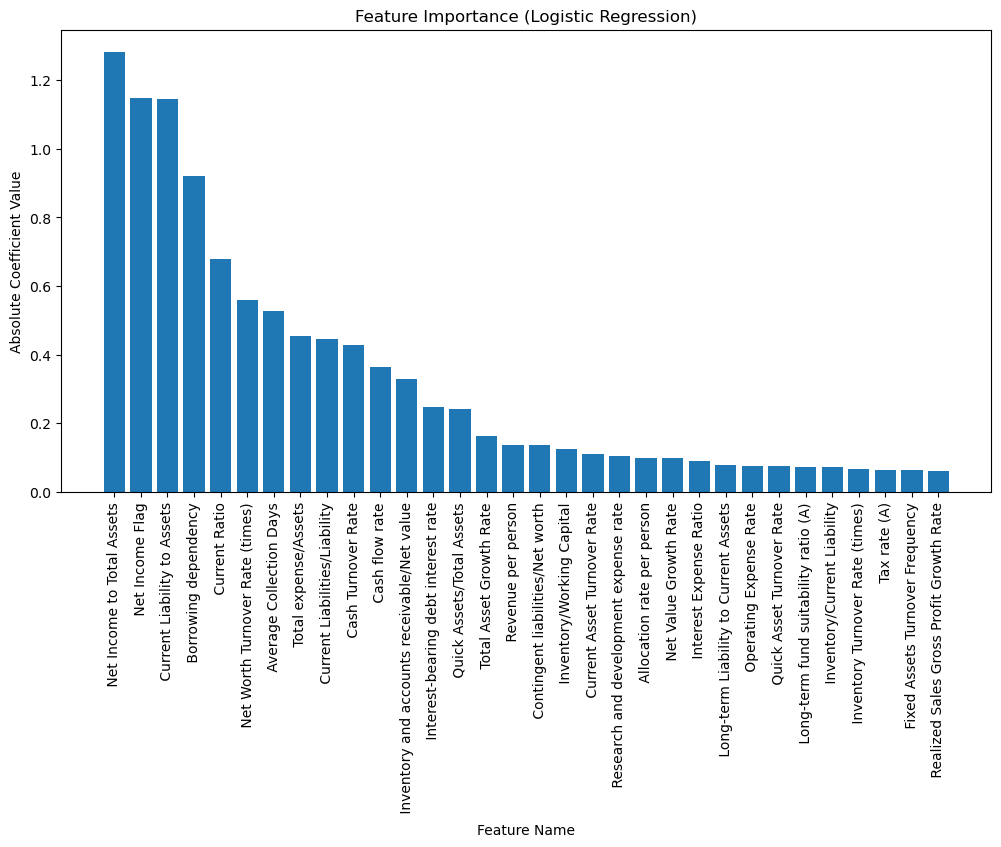

In [184]:
feature_df, omitted_df = feature_importance_logreg(logistic_l1, cut_off = 0.05)

In [185]:
omitted_df

,Omitted Feature,Omitted Importance
0,No-credit Interval,0.034291
1,Net Value Per Share (A),0.033482
2,Continuous Net Profit Growth Rate,0.032373
3,Cash/Current Liability,0.027916
4,Non-industry income and expenditure/revenue,0.022124
5,Cash Flow to Liability,0.011140
6,Liability-Assets Flag,0.000000
7,Total assets to GNP price,0.000000
8,Realized Sales Gross Margin,0.000000
